In [2]:
%matplotlib inline


# Why use EMD?
The motivations behind the Empirical Mode Demposition are straightforward but
sometimes get lost in a relatively complicated and technical literature. This
tutorial presents a quick summary of what EMD could add to your analysis and
what issues it can help to solve.


## Frequency spectra of dynamic and non-sinusoidal signals
A core challenge in signal processing is finding an intuitive representation
of the frequency content of complicated and dynamic signals. The most common
approach is to use methods based on the Fourier-transform - in which we
represent a signal with a set of sinusoidal basis functions. This is a very
powerful and flexible approach but has some short-comings when working with
dynamic or non-sinusoidal signals.

Let's take a look at an example. Here we make two oscillatory signals - one
with a sinusoidal waveform and one with a non-linearity.



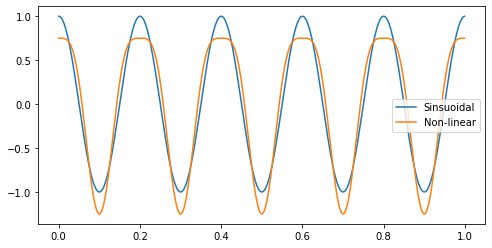

In [17]:
import emd
import numpy as np
from scipy import signal, ndimage
import matplotlib.pyplot as plt

sample_rate = 1000
seconds = 10
num_samples = sample_rate*seconds

time_vect = np.linspace(0, seconds, num_samples)

freq = 5

# Sinusoidal signal
x = np.cos(2*np.pi*freq*time_vect)

# Non-linear signal
y = np.cos(2*np.pi*freq*time_vect) + 0.25*np.cos(2*np.pi*freq*2*time_vect-np.pi)

# Quick summary figure
plt.figure(figsize=(8, 4))
plt.plot(time_vect[:sample_rate], x[:sample_rate])
plt.plot(time_vect[:sample_rate], y[:sample_rate])
plt.legend(['Sinsuoidal', 'Non-linear'])

# sphinx_gallery_thumbnail_number = 2

We can see that our non-linear signal has a wider trough and a sharper peak
than the sinusoid - many natural signals might have oscillatory features like
this. Unfortunately, the Fourier transform has to use multiple components to
represent this oscillation as its basis set fixed and unchanging over time.

As an illustration, lets compute a fast-Fourier transform on our two signals



Text(0, 0.5, 'Power')

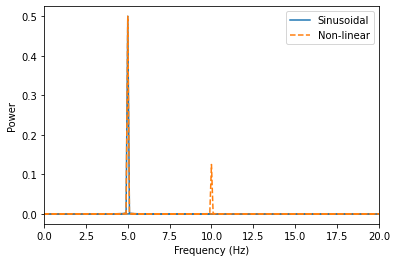

In [18]:
pxx = np.fft.fft(x) / len(x)
pyy = np.fft.fft(y) / len(x)
fft_f = np.fft.fftfreq(x.shape[0], d=time_vect[1]-time_vect[0])

plt.figure()
plt.plot(fft_f, np.abs(pxx))
plt.plot(fft_f, np.abs(pyy), '--')
plt.xlim(0, 20)
plt.legend(['Sinusoidal', 'Non-linear'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

Welch's periodogram shows us that both signals have high power at 5Hz - as we
would expect from our signal definition. However, the non-linear case has an
additional peak at 10Hz. This arises as the Fourier transform and related
methods needs to represent the non-linearity with a combination of strictly
linear basis functions. We only need a signal component to represent our
linear signal but the non-linear signal needs to use two. This is well
illustrated in the time domain.

First, we can use the parameters of the Fourier transform to recompute our basis signals.



In [19]:
comp1_amp = 2 * np.abs(pyy[50])
comp1_phase = np.arctan2(pyy[50].imag, pyy[50].real)
comp1 = comp1_amp * np.cos(2*np.pi*5*time_vect + comp1_phase)

comp2_amp = 2 * np.abs(pyy[100])
comp2_phase = np.arctan2(pyy[100].imag, pyy[100].real)
comp2 = comp2_amp * np.cos(2*np.pi*10*time_vect + comp2_phase)

print('Component 1 amp={0} and phase={1}'.format(comp1_amp, comp1_phase))
print('Component 2 amp={0} and phase={1}'.format(comp2_amp, comp2_phase))

Component 1 amp=0.9999422181181442 and phase=0.015707963267943756
Component 2 amp=0.2500380507261862 and phase=-3.1101767270538976


The values recovered from the fourier transform are very close to the
simulated values from the start. We see that the first component has an
amplitude very close to 1 and a phase close to zero, whilst the second
component has an amplitude close to 0.25 and a phase close to -pi.



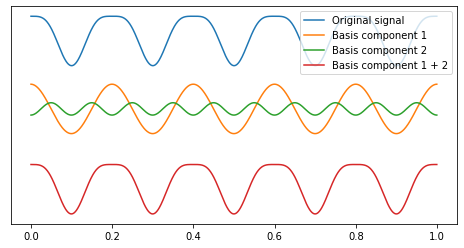

In [20]:
plt.figure(figsize=(8, 4), frameon=False)
plt.yticks([])
plt.plot(time_vect[:sample_rate], y[:sample_rate] + 3)
plt.plot(time_vect[:sample_rate], comp1[:sample_rate])
plt.plot(time_vect[:sample_rate], comp2[:sample_rate])
plt.plot(time_vect[:sample_rate], comp1[:sample_rate] + comp2[:sample_rate] - 3)
plt.legend(['Original signal', 'Basis component 1', 'Basis component 2', 'Basis component 1 + 2'])

The top signal in blue is our simulated signal, the orange and green signals
are the two components identified by the Fourier transform coefficients which
sum together to create the bottom signal in red.

It turns out that any signal can be represented by the summation of sets of
simple sinusoids - even extremely non-linear or disjoint signals like
triangular waves. This is a very powerful tool, but the need to include
multiple high frequency components, known as harmonics, can create
interpretation issues.  In a complex or noisy signal, it might not be clear
whether a peak in a power spectrum represents a harmonic of a low frequency
signal or a stand-alone high frequency signal. The problem gets worse if we
have several oscillations which are all creating separate harmonics. These
signals may be untangled using more complicated analysis of the interactions
between different Fourier components but these can get very complicated.



## Instantaneous Frequency



The Empirical Mode Decomposition offers a different perspective on this
problem. Instead of representing dynamic signals with combinations of static
basis functions, the EMD looks to isolate a small number of temporally
adaptive basis functions and derive dynamics in frequency and amplitude
directly from them.

These adaptive basis functions are called Intrinsic Mode Functions (IMFs) and
are isolated from the data using the 'sift' algorithm. This is a time-domain
algorithm which doesn't require a Fourier transform to separate out different
signals.

IMFs are defined by several features. They must be locally-symmetric around
zero and contain the same number of extrema as zero-crossings (or differ by
no more than 1). The 'sift' is a numerical algorithm for isolating signal
components with exactly these features. Any residual after the sift is a
non-oscillatory trend component.

Lets run a sift on our non-linear signal and plot the results.



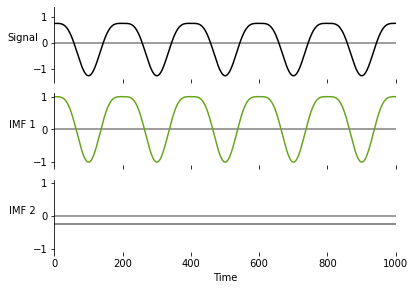

In [21]:
imf = emd.sift.sift(y)

emd.plotting.plot_imfs(imf[:sample_rate, :], cmap=True, scale_y=True)

The sift has identified two components, the first contains the oscillatory
signal with its non-sinusoidal shape intact whilst the second contains a
constant mean-term.



We can compute the instantaneous amplitude, frequency and phase of our IMF
using the Hilbert transform. This is a function which creates an 'analytic'
form of a signal that is extremely useful for extracting dynamic information
from a signal. Critically, the result of a Hilbert transform is only valid
for signals with very specific features. The definition of the sift ensures
that each resulting IMF does meet these criteria (or at least be very close).

This means that we can use the Hilbert transform to estimate instantaneous
frequencies directly from our IMFs. We don't need to use the Fourier
transform for this and so can avoid adding harmonic components into our
results.

Here, we compute the Hilbert transform from our IMFs



In [22]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')

...and plot up the resulting instantaneous frequency.



Text(0, 0.5, 'Frequency (Hz)')

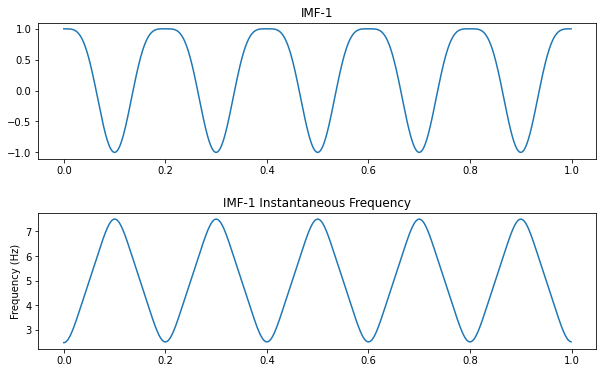

In [23]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)
plt.subplot(211)
plt.plot(time_vect[:sample_rate], imf[:sample_rate, 0])
plt.title('IMF-1')
plt.subplot(212)
plt.plot(time_vect[:sample_rate], IF[:sample_rate, 0])
plt.title('IMF-1 Instantaneous Frequency')
plt.ylabel('Frequency (Hz)')

This dynamic representation of frequency is able to adapt to the changing
waveform shape and describe the non-sinusoidal shape as a single smoothly
varying component rather than as two separate, static components.

We can compute a power spectrum using these principles called the Hilbert-Huang transform



Text(0, 0.5, 'Power')

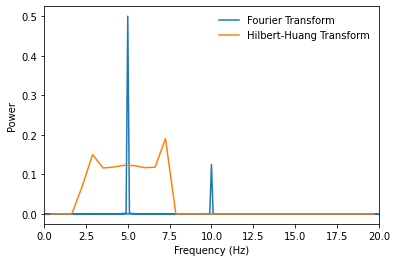

In [24]:
freq_range = (0.1, 20, 32)
hht_f, spec = emd.spectra.hilberthuang(IF, IA, freq_range, scaling='density')

plt.figure()
plt.plot(fft_f, np.abs(pyy))
plt.plot(hht_f, spec)
plt.legend(['Fourier Transform', 'Hilbert-Huang Transform'], frameon=False)
plt.xlim(0, 20)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

The Hilbert-Huang transform gives a summary of the dynamic spectral content
of the signal. It represents our non-linear signal as a distribution of
frequencies around 5Hz without adding an additional signal component.



## Time-resolution



Finally, the instantaneous frequency and amplitude from the Hilbert transform
allow us to see very rapid dynamics in oscillatory signals. Fourier methods
are able to see dynamic changes by applying the transform in a sliding window
but the choice of window size places an important constraint on the
time-frequency resolution of the transform. Longer windows have greater
frequency resolution as they are able to use a larger number of Fourier basis
components - however these longer windows necessarily lead to worse time
resolution.

In contrast, the instantaneous frequency stats naturally vary over time, so
no window choice is required. Let's take a closer look with a dynamic
simulation.



In [25]:
# Create a signal with a dynamic oscillation
z = emd.simulate.ar_oscillator(25, sample_rate, seconds, r=0.975)[:, 0]

First we compute the sift, frequency transform and the Hilbert-Huang spectrum



In [26]:
imf = emd.sift.sift(z)
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')

freq_range = (0.1, 50, 48)
hht_f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, mode='amplitude', sum_time=False)
hht = ndimage.gaussian_filter(hht, 1)

Next, we compute a short-time Fourier-transform. The ``nperseg`` variable
controls the window-length and time-frequency resolution. Higher values will
lead to greater precision in frequency and worse precision in time.



In [27]:
nperseg = 2048
ftf, ftt, ftZ = signal.stft(z, nperseg=nperseg, fs=sample_rate, noverlap=nperseg-1)

<ipython-input-28-b4148cca86aa>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ftt, ftf, np.abs(ftZ), cmap='hot_r')
<ipython-input-28-b4148cca86aa>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(time_vect, hht_f, hht, cmap='hot_r')


Text(0, 0.5, 'Frequency (Hz)')

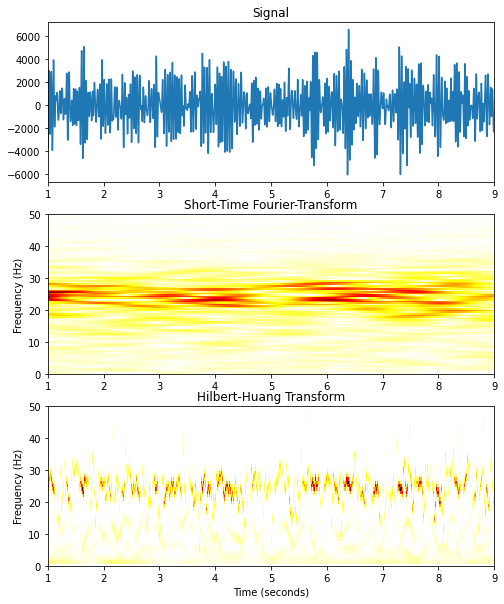

In [28]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
plt.plot(time_vect, z)
plt.xlim(1, 9)
plt.title('Signal')
plt.subplot(312)
plt.pcolormesh(ftt, ftf, np.abs(ftZ), cmap='hot_r')
plt.ylim(0, 50)
plt.xlim(1, 9)
plt.title('Short-Time Fourier-Transform')
plt.ylabel('Frequency (Hz)')
plt.subplot(313)
plt.pcolormesh(time_vect, hht_f, hht, cmap='hot_r')
plt.ylim(0, 50)
plt.title('Hilbert-Huang Transform')
plt.xlim(1, 9)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

Changes in oscillatory power are visible in both transforms but are noticeably
smoother in the STFT compared to the HHT. The blur in the STFT is due to the
windowing that we have applied, we can try to reduce this window size to
increase the temporal resolution of our transform



In [29]:
nperseg = 512
ftf, ftt, ftZ = signal.stft(z, nperseg=nperseg, fs=sample_rate, noverlap=nperseg-1)

Now we plot the two transforms together for another comparison.



<ipython-input-30-b4148cca86aa>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ftt, ftf, np.abs(ftZ), cmap='hot_r')
<ipython-input-30-b4148cca86aa>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(time_vect, hht_f, hht, cmap='hot_r')


Text(0, 0.5, 'Frequency (Hz)')

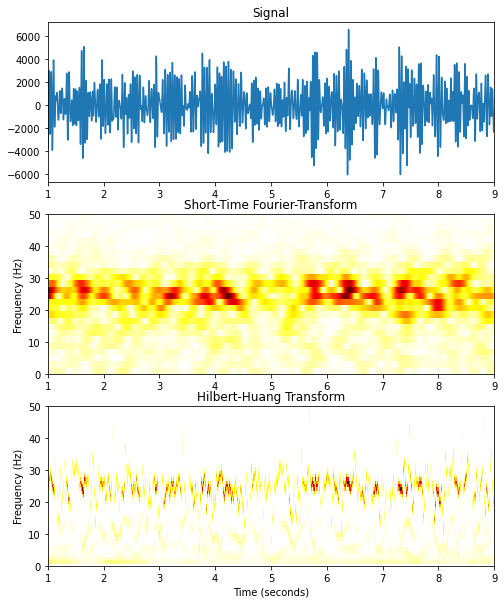

In [30]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
plt.plot(time_vect, z)
plt.xlim(1, 9)
plt.title('Signal')
plt.subplot(312)
plt.pcolormesh(ftt, ftf, np.abs(ftZ), cmap='hot_r')
plt.ylim(0, 50)
plt.xlim(1, 9)
plt.title('Short-Time Fourier-Transform')
plt.ylabel('Frequency (Hz)')
plt.subplot(313)
plt.pcolormesh(time_vect, hht_f, hht, cmap='hot_r')
plt.ylim(0, 50)
plt.title('Hilbert-Huang Transform')
plt.xlim(1, 9)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

Shortening the window-size in the STFT has reduced the temporal blur but
increased the blur in the frequency dimension. The HHT produces a sharper
image in both dimensions.



The remaining tutorials go into all of the above analysis in much more detail
and try to introduce the motivations and concepts behind EMD alongside a
range of practical examples. We also introduce some problems with the EMD and
how to recognise & reduce them - there is no free-lunch in signal processing!

